<a href="https://colab.research.google.com/github/Sshubam/FSM_ML_Assignments/blob/main/FSM_3_KMeans_PCA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K Means Clustering


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

In [ ]:
idf = pd.read_csv("/Users/sshubam/Downloads/IrisDataset.csv")
idf.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
idf['SepalWidthCm'] = (idf['SepalWidthCm'] - idf['SepalWidthCm'].mean() ) / idf['SepalWidthCm'].std()
idf['PetalWidthCm'] = (idf['PetalWidthCm'] - idf['PetalWidthCm'].mean() ) / idf['PetalWidthCm'].std()
idf['SepalLengthCm'] = (idf['SepalLengthCm'] - idf['SepalLengthCm'].mean() ) / idf['SepalLengthCm'].std()
idf['PetalLengthCm'] = (idf['PetalLengthCm'] - idf['PetalLengthCm'].mean() ) / idf['PetalLengthCm'].std()

In [ ]:
idf['Species'] = idf['Species'].map({'Iris-setosa': 1, 'Iris-versicolor' : 2, 'Iris-virginica' : 3})

In [ ]:
idf

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,-0.897674,1.028611,-1.336794,-1.308593,1
1,2,-1.139200,-0.124540,-1.336794,-1.308593,1
2,3,-1.380727,0.336720,-1.393470,-1.308593,1
3,4,-1.501490,0.106090,-1.280118,-1.308593,1
4,5,-1.018437,1.259242,-1.336794,-1.308593,1
...,...,...,...,...,...,...
145,146,1.034539,-0.124540,0.816888,1.443121,3
146,147,0.551486,-1.277692,0.703536,0.918985,3
147,148,0.793012,-0.124540,0.816888,1.050019,3
148,149,0.430722,0.797981,0.930239,1.443121,3


In [ ]:
# X = np.array(idf.loc[:, idf.columns != 'Species'].values)
# y = np.array(idf['Species'].values)

In [ ]:
cluster_data = idf[['SepalLengthCm',	'SepalWidthCm',	'PetalLengthCm'	,'PetalWidthCm']].copy(deep=True)
cluster_data.dropna(axis=0, inplace=True)
cluster_data.sort_values(by=['SepalLengthCm',	'SepalWidthCm',	'PetalLengthCm'	,'PetalWidthCm'], inplace=True)
cluster_array = np.array(cluster_data)

In [ ]:
def calc_distance(X1, X2):
    return (sum((X1 - X2)**2))**0.5

In [ ]:
# Assign cluster clusters based on closest centroid
def assign_clusters(centroids, cluster_array):
    clusters = []
    for i in range(cluster_array.shape[0]):
        distances = []
        for centroid in centroids:
            distances.append(calc_distance(centroid, 
                                           cluster_array[i]))
        cluster = [z for z, val in enumerate(distances) if val==min(distances)]
        clusters.append(cluster[0])
    return clusters

In [ ]:
# Calculate new centroids based on each cluster's mean
def calc_centroids(clusters, cluster_array):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids


In [ ]:
# Calculate variance within each cluster
def calc_centroid_variance(clusters, cluster_array):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        mean_repmat = np.matlib.repmat(cluster_mean, 
                                       current_cluster.shape[0],1)
        sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
    return sum_squares

In [ ]:
import numpy.matlib

In [ ]:
k = 3
cluster_vars = []
centroids = [cluster_array[i+2] for i in range(k)]
clusters = assign_clusters(centroids, cluster_array)
initial_clusters = clusters
print(0, round(np.mean(calc_centroid_variance(clusters, cluster_array))))
for i in range(5):
    centroids = calc_centroids(clusters, cluster_array)
    clusters = assign_clusters(centroids, cluster_array)
    cluster_var = np.mean(calc_centroid_variance(clusters, 
                                                 cluster_array))
    cluster_vars.append(cluster_var)
    print(i+1, round(cluster_var))

0 143
1 56
2 48
3 47
4 47
5 47


/var/folders/fl/4lrj_nhs3674_ddwctyg604m0000gn/T/ipykernel_55954/327498231.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bpi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('mean_ssd', bpi=150)


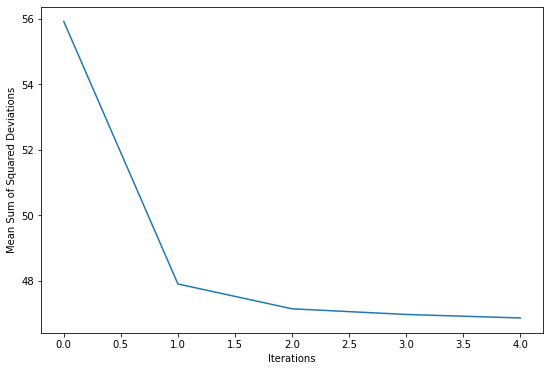

In [ ]:
plt.subplots(figsize=(9,6))
plt.plot(cluster_vars)
plt.xlabel('Iterations')
plt.ylabel('Mean Sum of Squared Deviations');
plt.savefig('mean_ssd', bpi=150)

/var/folders/fl/4lrj_nhs3674_ddwctyg604m0000gn/T/ipykernel_55954/271941416.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bpi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('initial_clusters', bpi=150)


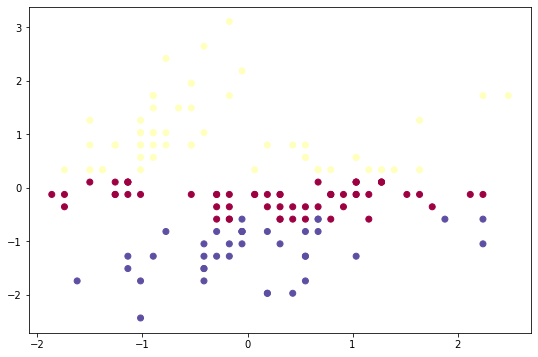

In [ ]:
plt.subplots(figsize=(9,6))
plt.scatter(x=cluster_array[:,0], y=cluster_array[:,1], 
            c=initial_clusters, cmap=plt.cm.Spectral);

plt.savefig('initial_clusters', bpi=150)

/var/folders/fl/4lrj_nhs3674_ddwctyg604m0000gn/T/ipykernel_55954/1255576074.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bpi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('converged_cluster', bpi=150)


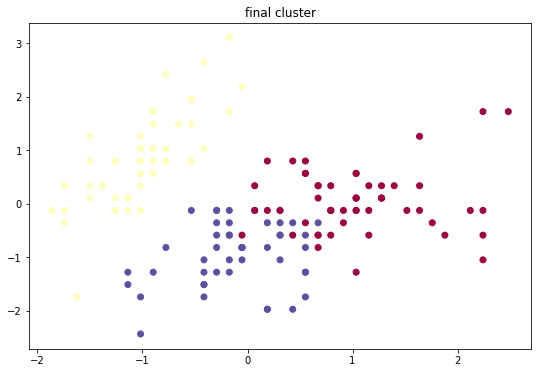

In [ ]:
plt.subplots(figsize=(9,6))
plt.scatter(x=cluster_array[:,0], y=cluster_array[:,1], 
            c=clusters, cmap=plt.cm.Spectral);
plt.savefig('converged_cluster', bpi=150)
plt.title("final cluster")
plt.show()

In [ ]:
results_df = cluster_data.join(idf[['Species']], 
                               how='left').reset_index(drop=True)
results_df = pd.concat([results_df, pd.DataFrame(initial_clusters, columns=['initial_cluster']), pd.DataFrame(clusters, columns=['converged_cluster'])], axis=1)

In [ ]:
results_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,initial_cluster,converged_cluster
0,-1.863780,-0.124540,-1.506822,-1.439627,1,0,1
1,-1.743017,-0.355171,-1.336794,-1.308593,1,0,1
2,-1.743017,-0.124540,-1.393470,-1.308593,1,0,1
3,-1.743017,0.336720,-1.393470,-1.308593,1,1,1
4,-1.622254,-1.738953,-1.393470,-1.177559,1,2,1
...,...,...,...,...,...,...,...
145,2.242172,-1.047062,1.780377,1.443121,3,2,0
146,2.242172,-0.585801,1.667025,1.050019,3,2,0
147,2.242172,-0.124540,1.326970,1.443121,3,0,0
148,2.242172,1.720502,1.667025,1.312087,3,1,0


In [ ]:
pivot_initial = (results_df.pivot_table(values=['Species'], 
                                        index=['initial_cluster'],
                                        aggfunc='mean'))
pivot_initial['label'] = ['Initial' for i in range(pivot_initial.shape[0])]

pivot_converged = results_df.pivot_table(values=['Species'], 
                                         index=['converged_cluster'],
                                         aggfunc='mean')
pivot_converged['label'] = ['Converged' for i in range(pivot_converged.shape[0])]

pivot_df = pd.concat([pivot_initial, pivot_converged], axis=0).reset_index()
pivot_df = pivot_df.rename({'index': 'Cluster',
                            'Species': 'Species name'}, axis=1)
results_df['converged_cluster'] = results_df['converged_cluster'].map({1: 1, 2: 2, 0: 3})

In [ ]:
results_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,initial_cluster,converged_cluster
0,-1.863780,-0.124540,-1.506822,-1.439627,1,0,1
1,-1.743017,-0.355171,-1.336794,-1.308593,1,0,1
2,-1.743017,-0.124540,-1.393470,-1.308593,1,0,1
3,-1.743017,0.336720,-1.393470,-1.308593,1,1,1
4,-1.622254,-1.738953,-1.393470,-1.177559,1,2,1
...,...,...,...,...,...,...,...
145,2.242172,-1.047062,1.780377,1.443121,3,2,3
146,2.242172,-0.585801,1.667025,1.050019,3,2,3
147,2.242172,-0.124540,1.326970,1.443121,3,0,3
148,2.242172,1.720502,1.667025,1.312087,3,1,3


In [ ]:
conditions = [results_df['Species'] == results_df['converged_cluster']]

#define choices
choices = ['True']

#create new column in DataFrame that displays results of comparisons
results_df['true_pred'] = np.select(conditions, choices, default='False')

#view the DataFrame
results_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,initial_cluster,converged_cluster,true_pred
0,-1.863780,-0.124540,-1.506822,-1.439627,1,0,1,True
1,-1.743017,-0.355171,-1.336794,-1.308593,1,0,1,True
2,-1.743017,-0.124540,-1.393470,-1.308593,1,0,1,True
3,-1.743017,0.336720,-1.393470,-1.308593,1,1,1,True
4,-1.622254,-1.738953,-1.393470,-1.177559,1,2,1,True
...,...,...,...,...,...,...,...,...
145,2.242172,-1.047062,1.780377,1.443121,3,2,3,True
146,2.242172,-0.585801,1.667025,1.050019,3,2,3,True
147,2.242172,-0.124540,1.326970,1.443121,3,0,3,True
148,2.242172,1.720502,1.667025,1.312087,3,1,3,True


In [ ]:
results_df['true_pred'].value_counts('True')

True     0.846667
False    0.153333
Name: true_pred, dtype: float64

# PCA

In [ ]:
import numpy as np

class PCA(object):
    """Dimension Reduction using Principal Component Analysis (PCA)

    It is the procces of computing principal components which explains the
    maximum variation of the dataset using fewer components.

    :type  n_components: int, optional
    :param n_components: Number of components to consider, if not set then
                         `n_components = min(n_samples, n_features)`, where
                         `n_samples` is the number of samples, and
                         `n_features` is the number of features (i.e.,
                         dimension of the dataset).

    Attributes
    ==========
        :type  covariance_: np.ndarray
        :param covariance_: Coviarance Matrix

        :type  eig_vals_: np.ndarray
        :param eig_vals_: Calculated Eigen Values

        :type  eig_vecs_: np.ndarray
        :param eig_vecs_: Calculated Eigen Vectors

        :type  explained_variance_: np.ndarray
        :param explained_variance_: Explained Variance of Each Principal Components

        :type  cum_explained_variance_: np.ndarray
        :param cum_explained_variance_: Cumulative Explained Variables
    """

    def __init__(self, n_components : int = None):
        """Default Constructor for Initialization"""

        self.n_components = n_components

    def fit_transform(self, X : np.ndarray):
        """Fit the PCA algorithm into the Dataset"""

        if not self.n_components:
            self.n_components = min(X.shape)

        self.covariance_ = np.cov(X.T)

        # calculate eigens
        self.eig_vals_, self.eig_vecs_ = np.linalg.eig(self.covariance_)

        # explained variance
        _tot_eig_vals = sum(self.eig_vals_)
        self.explained_variance_ = np.array([(i / _tot_eig_vals) * 100 for i in sorted(self.eig_vals_, reverse = True)])
        self.cum_explained_variance_ = np.cumsum(self.explained_variance_)

        # define `W` as `d x k`-dimension
        self.W_ = self.eig_vecs_[:, :self.n_components]

        print(X.shape, self.W_.shape)
        return X.dot(self.W_)

(150, 4) (4, 4)


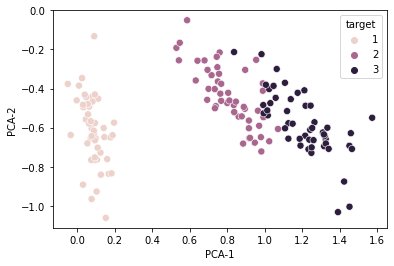

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# X, y = iris.data, iris.target
X = idf[['SepalLengthCm', 'SepalWidthCm','PetalLengthCm','PetalWidthCm']]
y = idf[['Species']]
X = MinMaxScaler().fit_transform(X)

# using the PCA function (defined above)
# to fit_transform the X value
# naming the PCA object as dPCA (d = defined)
PCA = PCA()
principalComponents = PCA.fit_transform(X)

# creating a pandas dataframe for the principal components
# and visualize the data using scatter plot
PCAResult = pd.DataFrame(principalComponents, columns = [f"PCA-{i}" for i in range(1, PCA.n_components + 1)])
PCAResult["target"] = y # possible as original order does not change

sns.scatterplot(x = "PCA-1", y = "PCA-2", data = PCAResult, hue = "target", s = 50)
# plt.scatter(x="PCA-1", y="PCA-2", data = PCAResult,color=['red','green','blue'] );
plt.show()

In [ ]:
#========================================================================================